In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision.datasets import MNIST
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torchvision.transforms import ToTensor

# Set Device

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load MNIST

In [5]:
MNIST_MEAN = 0.1307
MNIST_STD = 0.3081

transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Normalize((MNIST_MEAN,), (MNIST_STD,))
    ])

train_dataset = MNIST(root='../data', train=True, download=True, transform=transform)
test_dataset = MNIST(root='../data', train=False, download=True, transform=transform)

# MLP

In [6]:
class MLP(nn.Module):
    def __init__(self, input_shape, hidden_size, num_classes):
        super(MLP, self).__init__()
        self.input_shape = input_shape
        self.fc1 = nn.Linear(input_shape[1], hidden_size)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu1(out)
        out = self.fc2(out)
        out = self.softmax(out)
        return out

In [7]:
class TrainTest:
    def __init__(self, model, device) -> None:
        self.model = model
        self.device = device
        
    def train(self, num_epochs, train_dataset, batch_size, loss_function, optimizer):
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        
        for epoch in range(num_epochs):
            for i, (images, labels) in enumerate(train_loader):
                images = images.reshape(*self.model.input_shape).to(self.device)
                labels = labels.to(self.device)

                outputs = self.model(images)
                loss = loss_function(outputs, labels)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                if (i + 1) % 100 == 0:
                    self._print_log(epoch, num_epochs, i + 1, len(train_loader), loss.item())
                    
    def test(self, test_dataset, batch_size):
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
        
        with torch.no_grad():
            correct = 0
            total = 0
            for images, labels in test_loader:
                images = images.reshape(*self.model.input_shape).to(self.device)
                labels = labels.to(self.device)
                outputs = self.model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

            print(f'Accuracy on test dataset: {100 * correct / total}%')
            
    def _print_log(self, epoch, num_epochs, step, total_steps, loss):
        print(f'Epoch [{epoch + 1}/{num_epochs}], Step [{step}/{total_steps}], Loss: {loss:.4f}')
        
    def predict(self, x):
        x = x.reshape(*self.model.input_shape).to(self.device)
        outputs = self.model(x)
        _, predicted = torch.max(outputs.data, 1)
        return predicted
         

In [8]:
hidden_size = 50
num_classes = 10
num_epochs = 2
batch_size = 64
learning_rate = 0.001
input_shape = (-1, 784)

mlp_clf = MLP(input_shape, hidden_size, num_classes).to(device)

loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(mlp_clf.parameters(), lr=learning_rate)

TrainTest(mlp_clf, device).train(num_epochs, train_dataset, batch_size, loss_function, optimizer)

TrainTest(mlp_clf, device).test(test_dataset, batch_size)

Epoch [1/2], Step [100/938], Loss: 1.7355
Epoch [1/2], Step [200/938], Loss: 1.6238
Epoch [1/2], Step [300/938], Loss: 1.5739
Epoch [1/2], Step [400/938], Loss: 1.5461
Epoch [1/2], Step [500/938], Loss: 1.5804
Epoch [1/2], Step [600/938], Loss: 1.5567
Epoch [1/2], Step [700/938], Loss: 1.5231
Epoch [1/2], Step [800/938], Loss: 1.5747
Epoch [1/2], Step [900/938], Loss: 1.5845
Epoch [2/2], Step [100/938], Loss: 1.5401
Epoch [2/2], Step [200/938], Loss: 1.5773
Epoch [2/2], Step [300/938], Loss: 1.5643
Epoch [2/2], Step [400/938], Loss: 1.5667
Epoch [2/2], Step [500/938], Loss: 1.5499
Epoch [2/2], Step [600/938], Loss: 1.4885
Epoch [2/2], Step [700/938], Loss: 1.5458
Epoch [2/2], Step [800/938], Loss: 1.5290
Epoch [2/2], Step [900/938], Loss: 1.5581
Accuracy on test dataset: 93.97%


# LeNet

In [13]:
class LeNet(nn.Module):
    def __init__(self, input_shape):
        super(LeNet, self).__init__()
        self.input_shape = input_shape
        self.conv1 = nn.Conv2d(1, 6, 5, padding=2)
        self.pool1 = nn.AvgPool2d(2, stride=2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.pool2 = nn.AvgPool2d(2, 2)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = F.sigmoid(self.conv1(x))
        x = self.pool1(x)
        x = F.sigmoid(self.conv2(x))
        x = self.pool2(x)
        x = x.view(-1, 16 * 5 * 5)
        x = F.sigmoid(self.fc1(x))
        x = F.sigmoid(self.fc2(x))
        x = self.fc3(x)
        return x

In [15]:
num_epochs = 4
input_shape = (-1, 1, 28, 28)

leNet_clf = LeNet(input_shape).to(device)

loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(leNet_clf.parameters(), lr=learning_rate)

TrainTest(leNet_clf, device).train(num_epochs, train_dataset, batch_size, loss_function, optimizer)

TrainTest(leNet_clf, device).test(test_dataset, batch_size)

Epoch [1/4], Step [100/938], Loss: 2.3060
Epoch [1/4], Step [200/938], Loss: 1.5703
Epoch [1/4], Step [300/938], Loss: 0.9419
Epoch [1/4], Step [400/938], Loss: 0.5567
Epoch [1/4], Step [500/938], Loss: 0.4218
Epoch [1/4], Step [600/938], Loss: 0.4604
Epoch [1/4], Step [700/938], Loss: 0.2144
Epoch [1/4], Step [800/938], Loss: 0.3131
Epoch [1/4], Step [900/938], Loss: 0.3399
Epoch [2/4], Step [100/938], Loss: 0.2391
Epoch [2/4], Step [200/938], Loss: 0.2738
Epoch [2/4], Step [300/938], Loss: 0.1024
Epoch [2/4], Step [400/938], Loss: 0.1431
Epoch [2/4], Step [500/938], Loss: 0.2770
Epoch [2/4], Step [600/938], Loss: 0.1894
Epoch [2/4], Step [700/938], Loss: 0.2015
Epoch [2/4], Step [800/938], Loss: 0.0950
Epoch [2/4], Step [900/938], Loss: 0.1920
Epoch [3/4], Step [100/938], Loss: 0.1218
Epoch [3/4], Step [200/938], Loss: 0.1982
Epoch [3/4], Step [300/938], Loss: 0.2418
Epoch [3/4], Step [400/938], Loss: 0.1151
Epoch [3/4], Step [500/938], Loss: 0.0518
Epoch [3/4], Step [600/938], Loss:

# Test Shifted Image

In [37]:
def show_image(image, ax, title):
    ax.imshow(image.squeeze(), cmap='gray')
    ax.set_title(title)
    ax.axis('off')

      original shifted
LeNet 7        7
MLP   7        2


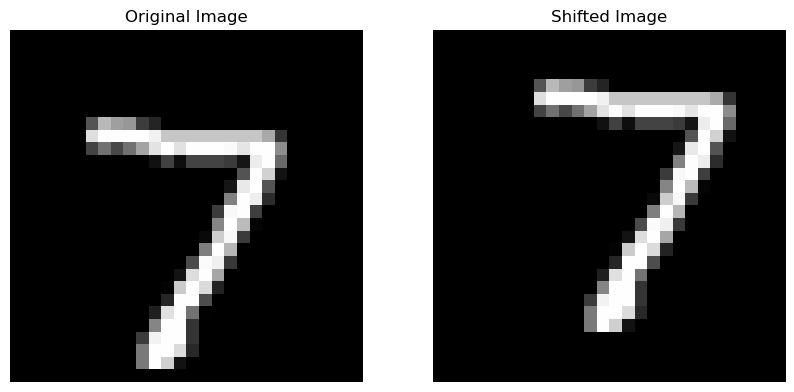

In [40]:
torch.manual_seed(42)

shift_x = 0.1
shift_y = 0.5
shift_transform = transforms.Compose([
    transforms.RandomAffine(degrees=0, translate=(shift_x, shift_y), fill=-MNIST_MEAN/MNIST_STD, )
])

index = 0
image, label = test_dataset[index]

shifted_image = shift_transform(image)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

show_image(image, ax1, "Original Image")
show_image(shifted_image, ax2, "Shifted Image")


print(f"{'':<6}original shifted")
print(f"LeNet {TrainTest(leNet_clf, device).predict(image)[0]:<8} {TrainTest(leNet_clf, device).predict(shifted_image)[0]}", )
print(f"MLP   {TrainTest(mlp_clf, device).predict(image)[0]:<8} {TrainTest(mlp_clf, device).predict(shifted_image)[0]}")

plt.savefig("../assets/Q3.png")
plt.show()